In [35]:
import numpy as np
import dreem
import os
import matplotlib.pyplot as plt
import math
import torch
import logging
from dreem.models.mlp import MLP
from dreem.models.model_utils import *
from dreem.datasets import SleapDataset
import torchtune.modules as tune
from dreem.models.transformer import TransformerEncoderLayer
from dreem.models import VisualEncoder
from dreem.models import GlobalTrackingTransformer

In [36]:
"""Module containing different position and temporal embeddings."""

logger = logging.getLogger("dreem.models")
# todo: add named tensors, clean variable names


class Embedding(torch.nn.Module):
    """Class that wraps around different embedding types.

    Used for both learned and fixed embeddings.
    """

    EMB_TYPES = {
        "temp": {},
        "pos": {"over_boxes"},
        "off": {},
        None: {},
    }  # dict of valid args:keyword params
    EMB_MODES = {
        "fixed": {"temperature", "scale", "normalize"},
        "learned": {"emb_num"},
        "off": {},
    }  # dict of valid args:keyword params

    def __init__(
        self,
        emb_type: str,
        mode: str,
        features: int,
        n_points: int = 1,
        emb_num: int = 16,
        over_boxes: bool = True,
        temperature: int = 10000,
        normalize: bool = False,
        scale: float | None = None,
        mlp_cfg: dict | None = None,
    ):
        """Initialize embeddings.

        Args:
            emb_type: The type of embedding to compute. Must be one of `{"temp", "pos", "off"}`
            mode: The mode or function used to map positions to vector embeddings.
                  Must be one of `{"fixed", "learned", "off"}`
            features: The embedding dimensions. Must match the dimension of the
                      input vectors for the transformer model.
            n_points: the number of points that will be embedded.
            emb_num: the number of embeddings in the `self.lookup` table (Only used in learned embeddings).
            over_boxes: Whether to compute the position embedding for each bbox coordinate (y1x1y2x2) or the centroid + bbox size (yxwh).
            temperature: the temperature constant to be used when computing the sinusoidal position embedding
            normalize: whether or not to normalize the positions (Only used in fixed embeddings).
            scale: factor by which to scale the positions after normalizing (Only used in fixed embeddings).
            mlp_cfg: A dictionary of mlp hyperparameters for projecting embedding to correct space.
                    Example: {"hidden_dims": 256, "num_layers":3, "dropout": 0.3}
        """
        self._check_init_args(emb_type, mode)

        super().__init__()

        self.emb_type = emb_type
        self.mode = mode
        self.features = features
        self.emb_num = emb_num
        self.over_boxes = over_boxes
        self.temperature = temperature
        self.normalize = normalize
        self.scale = scale
        self.n_points = n_points

        if self.normalize and self.scale is None:
            self.scale = 2 * math.pi

        if self.emb_type == "pos" and mlp_cfg is not None and mlp_cfg["num_layers"] > 0:
            if self.mode == "fixed":
                self.mlp = MLP(
                    input_dim=n_points * self.features,
                    output_dim=self.features,
                    **mlp_cfg,
                )
            else:
                in_dim = (self.features // (4 * n_points)) * (4 * n_points)
                self.mlp = MLP(
                    input_dim=in_dim,
                    output_dim=self.features,
                    **mlp_cfg,
                )
        else:
            self.mlp = torch.nn.Identity()

        self._emb_func = lambda tensor: torch.zeros(
            (tensor.shape[0], self.features), dtype=tensor.dtype, device=tensor.device
        )  # turn off embedding by returning zeros

        self.lookup = None

        if self.mode == "learned":
            if self.emb_type == "pos":
                self.lookup = torch.nn.Embedding(
                    self.emb_num * 4 * self.n_points, self.features // (4 * n_points)
                )
                self._emb_func = self._learned_pos_embedding
            elif self.emb_type == "temp":
                self.lookup = torch.nn.Embedding(self.emb_num, self.features)
                self._emb_func = self._learned_temp_embedding

        elif self.mode == "fixed":
            if self.emb_type == "pos":
                self._emb_func = self._sine_box_embedding
            elif self.emb_type == "temp":
                self._emb_func = self._sine_temp_embedding

    def _check_init_args(self, emb_type: str, mode: str):
        """Check whether the correct arguments were passed to initialization.

        Args:
            emb_type: The type of embedding to compute. Must be one of `{"temp", "pos", ""}`
            mode: The mode or function used to map positions to vector embeddings.
                Must be one of `{"fixed", "learned"}`

        Raises:
            ValueError:
              * if the incorrect `emb_type` or `mode` string are passed
            NotImplementedError: if `emb_type` is `temp` and `mode` is `fixed`.
        """
        if emb_type.lower() not in self.EMB_TYPES:
            raise ValueError(
                f"Embedding `emb_type` must be one of {self.EMB_TYPES} not {emb_type}"
            )

        if mode.lower() not in self.EMB_MODES:
            raise ValueError(
                f"Embedding `mode` must be one of {self.EMB_MODES} not {mode}"
            )

    def forward(self, seq_positions: torch.Tensor) -> torch.Tensor:
        """Get the sequence positional embeddings.

        Args:
            seq_positions:
                * An (`N`, 1) tensor where seq_positions[i] represents the temporal position of instance_i in the sequence.
                * An (`N`, n_anchors x 4) tensor where seq_positions[i, j, :] represents the [y1, x1, y2, x2] spatial locations of jth point of instance_i in the sequence.

        Returns:
            An `N` x `self.features` tensor representing the corresponding spatial or temporal embedding.
        """
        emb = self._emb_func(seq_positions)

        if emb.shape[-1] != self.features:
            raise RuntimeError(
                (
                    f"Output embedding dimension is {emb.shape[-1]} but requested {self.features} dimensions! \n"
                    f"hint: Try turning the MLP on by passing `mlp_cfg` to the constructor to project to the correct embedding dimensions."
                )
            )
        return emb

    def _torch_int_div(
        self, tensor1: torch.Tensor, tensor2: torch.Tensor
    ) -> torch.Tensor:
        """Perform integer division of two tensors.

        Args:
            tensor1: dividend tensor.
            tensor2: divisor tensor.

        Returns:
            torch.Tensor, resulting tensor.
        """
        return torch.div(tensor1, tensor2, rounding_mode="floor")

    def _sine_box_embedding(self, boxes: torch.Tensor) -> torch.Tensor:
        """Compute sine positional embeddings for boxes using given parameters.

         Args:
             boxes: the input boxes of shape N, n_anchors, 4 or B, N, n_anchors, 4
                    where the last dimension is the bbox coords in [y1, x1, y2, x2].
                    (Note currently `B=batch_size=1`).

        Returns:
             torch.Tensor, the sine positional embeddings
             (embedding[:, 4i] = sin(x)
              embedding[:, 4i+1] = cos(x)
              embedding[:, 4i+2] = sin(y)
              embedding[:, 4i+3] = cos(y)
              )
        """
        if self.scale is not None and self.normalize is False:
            raise ValueError("normalize should be True if scale is passed")

        if len(boxes.size()) == 3:
            boxes = boxes.unsqueeze(0)

        if self.normalize:
            boxes = boxes / (boxes[:, :, -1:] + 1e-6) * self.scale

        dim_t = torch.arange(self.features // 4, dtype=torch.float32)

        dim_t = self.temperature ** (
            2 * self._torch_int_div(dim_t, 2) / (self.features // 4)
        )

        # (b, n_t, n_anchors, 4, D//4)
        pos_emb = boxes[:, :, :, :, None] / dim_t.to(boxes.device)

        pos_emb = torch.stack(
            (pos_emb[:, :, :, :, 0::2].sin(), pos_emb[:, :, :, :, 1::2].cos()), dim=4
        )
        pos_emb = pos_emb.flatten(2).squeeze(0)  # (N_t, n_anchors * D)

        pos_emb = self.mlp(pos_emb)

        pos_emb = pos_emb.view(boxes.shape[1], self.features)

        return pos_emb

    def _sine_temp_embedding(self, times: torch.Tensor) -> torch.Tensor:
        """Compute fixed sine temporal embeddings.

        Args:
            times: the input times of shape (N,) or (N,1) where N = (sum(instances_per_frame))
            which is the frame index of the instance relative
            to the batch size
            (e.g. `torch.tensor([0, 0, ..., 0, 1, 1, ..., 1, 2, 2, ..., 2,..., B, B, ...B])`).

        Returns:
            an n_instances x D embedding representing the temporal embedding.
        """
        T = times.int().max().item() + 1
        d = self.features
        n = self.temperature

        positions = torch.arange(0, T).unsqueeze(1)
        temp_lookup = torch.zeros(T, d, device=times.device)

        denominators = torch.pow(
            n, 2 * torch.arange(0, d // 2) / d
        )  # 10000^(2i/d_model), i is the index of embedding
        temp_lookup[:, 0::2] = torch.sin(
            positions / denominators
        )  # sin(pos/10000^(2i/d_model))
        temp_lookup[:, 1::2] = torch.cos(
            positions / denominators
        )  # cos(pos/10000^(2i/d_model))

        temp_emb = temp_lookup[times.int()]
        return temp_emb  # .view(len(times), self.features)

In [62]:
# create Embedding object
emb_t = Embedding(emb_type="temp",mode="fixed",features=1024,emb_num=16,n_points=1,temperature=10000)
emb_p = Embedding(emb_type="pos",mode="fixed",features=1024,emb_num=16,n_points=1,temperature=10000)

In [39]:
# get sample crops from training data to pass through the network
train_path = "/home/jovyan/talmolab-smb/datasets/mot/microscopy/airyscan_proofread/Final/dreem-train"
# train_path = "/Users/mustafashaikh/dreem-data/dreem-train"
data = SleapDataset([os.path.join(train_path,"10-1.slp")], [os.path.join(train_path,"10-1.mp4")], crop_size=64,
                   mode="train", clip_length=32, anchors="centroid")

In [40]:
# get a list of all instances; this is the format that the model pipeline uses as input data
ref_instances = []
for frame in data[0]:
    for instance in frame.instances:
        ref_instances.append(instance)

In [41]:
# get the vector of times using the list of crops+labels
# query_instance is the instances in last frame (set to None)
ref_times, query_times = get_times(ref_instances, None)

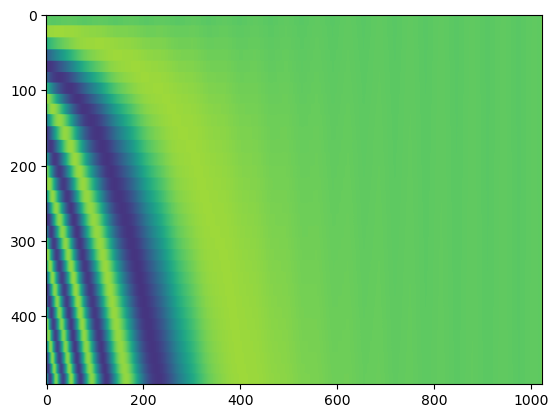

In [8]:
# call fixed temporal embedding with the vector of 'times'
plt.imshow(emb(ref_times).numpy(), aspect='auto')

In [43]:
feat_dim = 1024
xfmr_encoder = TransformerEncoderLayer(d_model=feat_dim, nhead=8)
visual_encoder = VisualEncoder(d_model=feat_dim, model_name="resnet18")

In [44]:
def extract_features(
        instances: list["Instance"], 
        visual_encoder: "dreem.models.VisualEncoder",
        force_recompute: bool = False
    ) -> None:
        """Extract features from instances using visual encoder backbone.

        Args:
            instances: A list of instances to compute features for
            VisualEncoder : pass an instance of a visual encoder
            force_recompute: indicate whether to compute features for all instances regardless of if they have instances
        """
        if not force_recompute:
            instances_to_compute = [
                instance
                for instance in instances
                if instance.has_crop() and not instance.has_features()
            ]
        else:
            instances_to_compute = instances

        if len(instances_to_compute) == 0:
            return
        elif len(instances_to_compute) == 1:  # handle batch norm error when B=1
            instances_to_compute = instances

        crops = torch.concatenate([instance.crop for instance in instances_to_compute])

        features = visual_encoder(crops)

        for i, z_i in enumerate(features):
            instances_to_compute[i].features = z_i

In [92]:
# partial forward pass of the transformer - up until the encoder

def prepare_for_xfmr(ref_instances):
    # extract visual encoder features from instance object; shape=(1,n_instances,d=1024)
    ref_features = torch.cat(
                [instance.features for instance in ref_instances], dim=0
            ).unsqueeze(0)

    # window_length = len(frames)
    # instances_per_frame = [frame.num_detected for frame in frames]
    total_instances = len(ref_instances)
    embed_dim = ref_features.shape[-1]
    # print(f'T: {window_length}; N: {total_instances}; N_t: {instances_per_frame} n_reid: {reid_features.shape}')
    ref_boxes = get_boxes(ref_instances)  # (n_instances,1,4)
    ref_boxes = torch.nan_to_num(ref_boxes, -1.0)
    ref_times, query_times = get_times(ref_instances, query_instances=None)

    # clip length 
    window_length = len(ref_times.unique())

    # computes the temporal embedding vector for each instance
    ref_temp_emb = emb_t(ref_times)
    # computes the positional embedding vector for each instance
    ref_pos_emb = emb_p(ref_boxes)

    return_embedding=False
    if return_embedding:
        for i, instance in enumerate(ref_instances):
            instance.add_embedding("pos", ref_pos_emb[i])
            instance.add_embedding("temp", ref_temp_emb[i])

    # we need a single vector so average the temporal and spatial embeddings
    ref_emb = (ref_pos_emb + ref_temp_emb) / 2.0

    # add a new dim at the beginning to represent the batch size (in our case 1)
    ref_emb = ref_emb.view(1, total_instances, embed_dim)

    ref_emb = ref_emb.permute(1, 0, 2)  # (total_instances, batch_size, embed_dim)

    batch_size, total_instances, embed_dim = ref_features.shape

    ref_features = ref_features.permute(
        1, 0, 2
    )  # (total_instances, batch_size, embed_dim); note batch_size = 1

    return ref_features

In [45]:
# pass instances through visual encoder to get the feature vector (q,k,v)
extract_features(ref_instances, visual_encoder)

In [123]:
# prepare data and apply rope
rope = tune.RotaryPositionalEmbeddings(feat_dim)

ref_features = torch.cat(
                [instance.features for instance in ref_instances], dim=0
            ).unsqueeze(0)

# input must be of shape (num_batches, num_instances, num_attn_heads, d_model)
# use num_heads=1 to use torch ROPE; we pass this into torch multiheadattn later which doesn't 
# use num_heads in the input data
ref_features = torch.unsqueeze(ref_features, 2)
rope_ref_feat = rope(ref_features)


torch.Size([1, 491, 1, 1024])

In [93]:
encoder_queries = prepare_for_xfmr(ref_instances)
encoder_features = xfmr_encoder(
    encoder_queries, pos_emb=ref_emb
)  # (total_instances, batch_size, embed_dim)

### Rotary Positional Embeddings